# MTI under homo assumption

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from obspy.imaging.beachball import beachball
from obspy.imaging.beachball import beach

from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.linalg import lstsq

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


In [1]:
from pyfrac.modelling.kirchhoff import Kirchhoff
from pyfrac.mtsolvers.homo_mti import collect_source_angles, pwave_zcomp_Greens
from pyfrac.mtsolvers.mtutils import get_mt_computation_dict


# 3D Model - Homo

In [3]:
# Velocity Model
nx, ny, nz = 45, 50, 75
dx, dy, dz = 4, 4, 4
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 1000 # initial velocity
kv = 0. # gradient
vel = v0 * np.ones([nx, ny, nz])

(3, 132)
[[  4 164 148 132 116 100  84  68  52  36  20   4 164 148]
 [  4   4  20  36  52  68  84 100 116 132 148 164 164 180]
 [  4   4   4   4   4   4   4   4   4   4   4   4   4   4]]


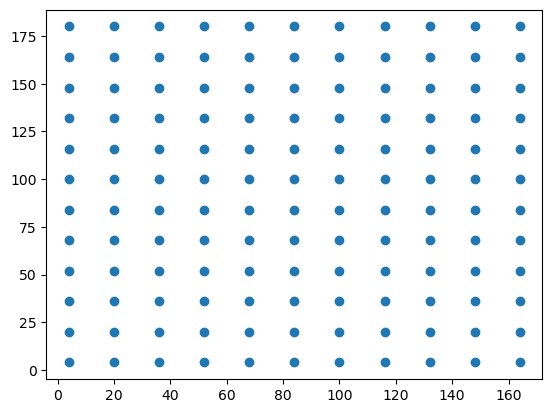

In [4]:
# RECEIVERS
dr_xyz = 4*dx

grid_rx_locs = np.arange(dx, (dx*nx)-dx, dr_xyz)
grid_ry_locs = np.arange(dy, (dy*ny)-dy, dr_xyz)

rx, ry, rz = np.meshgrid(grid_rx_locs,
                         grid_ry_locs,
                         dz) 
recs = np.vstack((rx.flatten(), ry.flatten(), rz.flatten()))
nr = recs.shape[1]

plt.scatter(rx,ry)
print(recs.shape)
print(recs[:,::10])

## Get all necessary components

In [5]:
# TRAVEL TIME TABLE
trav = Kirchhoff._traveltime_table(z, 
                                   x, 
                                   y=y, 
                                   recs=recs, 
                                   vel=vel, 
                                   mode='eikonal')

TTT_full = trav.reshape(nx,ny,nz,nr).transpose([3,0,1,2])

In [6]:
gamma_sourceangles, dist_table = collect_source_angles(x,y,z, reclocs=recs, nc=3)

In [7]:
MT_comp_dict = get_mt_computation_dict()  # This keeps everything nice and clean in the later G compute

## Compute Greens for specific source (location and frequency)

In [8]:
omega_p = 25  # Assume central frequency of 25Hz
sloc_ind = [20, 25, 50]  # As indices of velocity model

In [9]:
G_z = pwave_zcomp_Greens(gamma_sourceangles,
                       dist_table,
                       sloc_ind,
                       omega_p,
                       vel,
                       MT_comp_dict)

# Single Example

In [ ]:
mt = -1 * np.array([0,0,0,1,0,0])

## Running Computes (100% Inverse Crime!)

In [10]:
MT_list = [np.array([1,1,1,0,0,0]),
           -1 * np.array([1,1,1,0,0,0]),
           -1 * np.array([0,0,0,1,0,0]),
           np.array([1,-1,0,0,0,0]),
           np.array([-1,0,1,0,0,0]),
           np.array([0,-1,1,0,0,0]),
           np.array([1,-2,1,0,0,0]),
           np.array([-2,1,1,0,0,0]),
          ]

[1 1 1 0 0 0]
[-1 -1 -1  0  0  0]
[ 0  0  0 -1  0  0]
[ 1 -1  0  0  0  0]
[-1  0  1  0  0  0]
[ 0 -1  1  0  0  0]
[ 1 -2  1  0  0  0]
[-2  1  1  0  0  0]


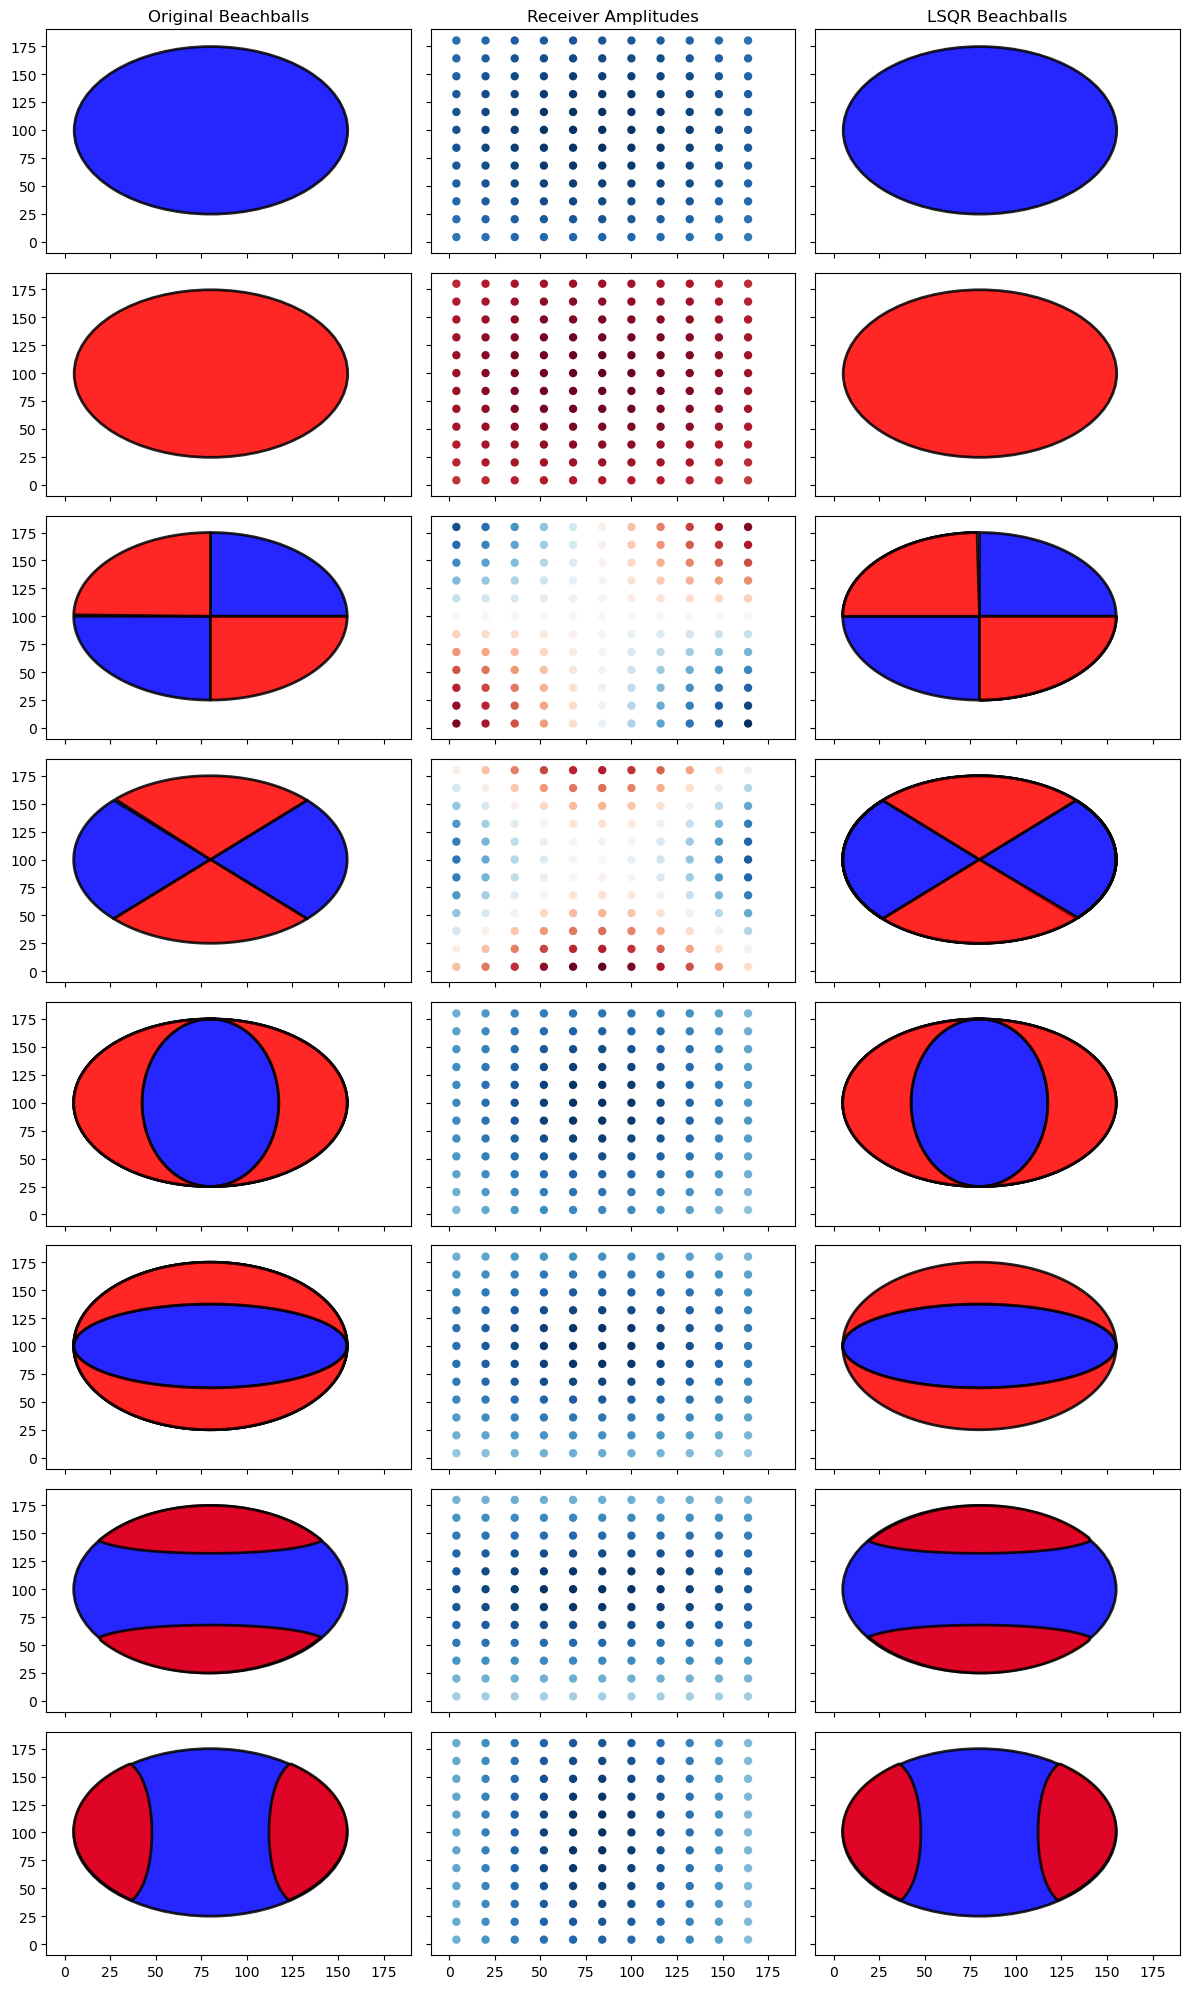

In [11]:
fig,axs = plt.subplots(len(MT_list),3, figsize=[12,20], sharex=True, sharey=True)
for ax in axs.ravel(): ax.set_xlim(-10,190); ax.set_ylim(-10,190)
for i,MT in enumerate(MT_list):

    # For beachball swap x and z locs
    MT_BB = MT.copy()
    MT_BB[0], MT_BB[2] = MT_BB[2], MT_BB[0]
    MT_BB[5] = MT_BB[3]
    MT_BB[3] = MT_BB[4]
    b = beach(MT_BB, linewidth=2, alpha=0.85, width=150, xy=[sloc_ind[0]*dx,sloc_ind[1]*dy], bgcolor='r')
    b.set_zorder(10)
    axs[i,0].add_collection(b) 
    
    # FORWARD
    u_zp = np.matmul(G_z.T, MT)
    axs[i,1].scatter(recs[0], recs[1], c=u_zp.squeeze(), s=25, marker='o', cmap='RdBu', vmin=-np.max(abs(u_zp)), vmax=np.max(abs(u_zp)))
    print(MT)
    # BACKWARD LEAST SQUARES
    MT_ls, res, rnk, s  = lstsq(G_z.T, u_zp)

    # For beachball swap x and z locs
    MT_BB_ls = MT_ls.copy()
    MT_BB_ls[0], MT_BB_ls[2] = MT_BB_ls[2], MT_BB_ls[0]
    MT_BB_ls[5] = MT_BB_ls[3]
    MT_BB_ls[3] = MT_BB_ls[4]
    b_ls = beach(MT_BB_ls, linewidth=2, alpha=0.85, width=150, xy=[sloc_ind[0]*dx,sloc_ind[1]*dy], bgcolor='r')
    b_ls.set_zorder(10)
    axs[i,2].add_collection(b_ls) 

axs[0,0].set_title('Original Beachballs')
axs[0,1].set_title('Receiver Amplitudes')
axs[0,2].set_title('LSQR Beachballs')

plt.tight_layout()
plt.savefig('MTI_InverseCrime.png')